# 1B - Model Generation with Sierra Leone Data Only

Variable selection and model training applied to the Sierra Leone data only.

# Initialization

In [78]:
import pandas as pd
from os import listdir, makedirs
from os.path import isfile, join, exists

# This disables the warnings from RPy2 when R loads libraries that in turn load other dependencies
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Use the RWinOut instead of rpy2.ipython to get output on windows 
# https://bitbucket.org/rpy2/rpy2/issues/125/set_writeconsole-not-working-on-windows
# https://github.com/vitorcurtis/RWinOut
#%load_ext RWinOut
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [79]:
%%R

# Load required R libraries

library(rms)
library(Hmisc)
library(glmnet)
library(mvnormtest)
library(BaylorEdPsych)
library(MissMech)

In [80]:
%%R 

# Random seed for reproducibility. Is reset at the beginning of each 
# calculating that involves randomization, so cells can be run in 
# arbitrary order and still reproduce results.

random_seed <- 151 

In [81]:
# Data file and modeling parameters

src_data_file = '../data/data.csv'
 
include_temp = True   # Include body temperature into all models
include_ctrt = True   # Include the referral time x Ct term into the parsimonious models
use_sat_impute = True # Use imputation from saturated model in all reduced models

num_imp = 100   # Number of multiple imputations
num_boot = 200  # Number of bootstrap samples

In [82]:
# Some utility functions in Python

# Replaces PatientAge and FeverTemperature by Restricted Cubic Splines of order 3
def addRCSTerms(model_formula):
    formula = model_formula.replace('PatientAge', 'rcs(PatientAge,3)')
    formula = formula.replace('FeverTemperature', 'rcs(FeverTemperature,3)')    
    return formula

def makeImputeFormula(out_var, pred_vars):
    imp_vars = pred_vars.copy()
    if 'FeverTemperature' in imp_vars and not 'Fever' in imp_vars: 
        imp_vars += ['Fever']
    if 'DaysSinceSymptomFeverOnset*cycletime' in imp_vars:
        imp_vars.remove('DaysSinceSymptomFeverOnset*cycletime')        
    formula = '~' + '+'.join([out_var] + imp_vars)
    return formula

def makeLogRegFormula(out_var, pred_vars):
    formula = addRCSTerms(out_var + '~' + '+'.join(pred_vars))
    return formula

def createModelFolder(path):    
    if not exists(path):
        makedirs(path)
    return path

In [83]:
%%R 

# Some utility functions in R

# Trims leading and trailing whitespaces
# https://stackoverflow.com/a/21882152
trim <- function(x) {
    return(gsub("(^[[:space:]]+|[[:space:]]+$)", "", x))
}

# Extract single frame from MI data
# https://stackoverflow.com/a/42820029
getImpute <- function(impute, data = src_data, im = 1) {
  cbind.data.frame(impute.transcan(x = impute, 
                                   imputation = im, 
                                   data = data, 
                                   list.out = TRUE, 
                                   pr = FALSE))
}

# Auxiliary (X^3)+
cubic <- function(u) {
   t <- max(0, u)
   return(t * t * t)
}

# Calculates the RCS term given the valuex, the term index, and the knots
rcsFun <- function(x, term, knots) {
    k <- length(knots) 
    j <- term
    t <- knots
    c <- (t[k] - t[1]) * (t[k] - t[1])
    value <- +cubic(x - t[j])
             -cubic(x - t[k - 1]) * (t[k] - t[j])/(t[k] - t[k-1])
             +cubic(x - t[k]) * (t[k - 1] - t[j])/(t[k] - t[k-1]) 
    return(value / c)  
}

# Arrange dataframe vars by position
# 'vars' must be a named vector, e.g. c("var.name"=1)
# https://stackoverflow.com/a/37009127
arrangeVars <- function(data, vars) {
    # Stop if not a data.frame (but should work for matrices as well)
    stopifnot(is.data.frame(data))

    # Sort out inputs
    data.nms <- names(data)
    var.nr <- length(data.nms)
    var.nms <- names(vars)
    var.pos <- vars
    
    # Sanity checks
    stopifnot(!any(duplicated(var.nms)), 
              !any(duplicated(var.pos)))
    stopifnot(is.character(var.nms), 
              is.numeric(var.pos))
    stopifnot(all(var.nms %in% data.nms))
    stopifnot(all(var.pos > 0), 
              all(var.pos <= var.nr))

    # Prepare output
    out.vec <- character(var.nr)
    out.vec[var.pos] <- var.nms
    out.vec[-var.pos] <- data.nms[ !(data.nms %in% var.nms) ]
    stopifnot( length(out.vec)==var.nr )

    # Re-arrange vars by position
    data <- data[, out.vec]
    return(data)
}

saveToTXT <- function(obj, dir, fn) {
    sink(paste0(dir, "/", fn), append=FALSE, split=FALSE)
    print(obj)
    sink()    
}

saveToPDF <- function(obj, dir, fn) {
    pdf(paste0(dir, "/", fn), useDingbats=FALSE)
    plot(obj)
    dev.off()
}

saveModelToCSV <- function(f, vars, dir) {
    terms = names(f$coefficients)
    coeff = unname(f$coefficients)

    # Extract RCS knots from model specs. 
    # This code is now specific to get the knots for age and fever temperature, 
    # but it could be generalized easily by providing a list with all the 
    # variables modeled as RCS.
    
    spec = specs(f)
    # print(str(spec)) # This is useful to understand the structure of the object
    
    ageIdx <- which(vars == "PatientAge")
    tempIdx <- which(vars == "FeverTemperature")
    prodIdx <- which(vars == "DaysSinceSymptomFeverOnset*cycletime")
    
    ageKnots <- spec$how.modeled[ageIdx, 2]
    tempKnots <- spec$how.modeled[tempIdx, 2]
    ageKnots <- trim(ageKnots)
    tempKnots <- trim(tempKnots)

    types <- rep.int("linear", length(terms))
    knots = rep.int("none", length(terms))

    age0 <- which(terms == "PatientAge")
    age1 <- which(terms == "PatientAge'")

    temp0 <- which(terms == "FeverTemperature")
    temp1 <- which(terms == "FeverTemperature'")

    prod0 <- which(terms == "cycletime * DaysSinceSymptomFeverOnset")
    
    types[age0] <- "RCS0"
    types[age1] <- "RCS1"
    knots[age1] <- ageKnots

    types[temp0] <- "RCS0"
    types[temp1] <- "RCS1"
    knots[temp1] <- tempKnots
    
    types[prod0] = "product"

    model <- data.frame("Term" = terms, "Coefficient" = coeff, "Type" = types, "Knots" = knots)
    write.table(model, file = paste0(dir, "/model.csv"), sep = ",", row.names=FALSE, qmethod = "double")    
}

saveDescription <- function(f, vars, dir) {
    print(f)
    saveToTXT(f, dir, "model.txt")
    saveToTXT(specs(f), dir, "specs.txt")
    
    saveModelToCSV(f, vars, dir)    
}

saveEvaluation <- function(an, val, cal, dir) {
    print(val)
    plot(cal)

    saveToTXT(an, dir, "anova.txt")
    saveToPDF(an, dir, "anova.pdf")

    saveToTXT(val, dir, "validation.txt")
    saveToPDF(cal, dir, "calibration.pdf")    
}

generateModel <- function(rseed, nimp, nboot, fimp, flgr, sdat, vars, dir) {
    set.seed(rseed)
    
    # Impute data and fit pooled model
    imp_res <- aregImpute(as.formula(fimp), data=sdat, n.impute=nimp)
    pool_mdl <- fit.mult.impute(as.formula(flgr), lrm, imp_res, data=sdat)

    # Calculate ANOVA and validation/calibration
    mdl_anv <- anova(pool_mdl)
    mdl_upd <- update(pool_mdl, x=TRUE, y=TRUE)
    mdl_val <- validate(mdl_upd, B=nboot)
    mdl_cal <- calibrate(mdl_upd, B=nboot)

    # Calculate distribution summaries for potential predictor variables
    saveDescription(f=pool_mdl, vars=vars, dir=dir)
    saveEvaluation(an=mdl_anv, val=mdl_val, cal=mdl_cal, dir=dir)

#     f <- mdl_upd    
#     df <- getImpute(impute=imp_res, im=1)
#     dd <- datadist(df)
    # Trick to reset the options, as described in https://www.burns-stat.com/the-options-mechanism-in-r/
#     oldopt <- options(datadist='dd') 
#     on.exit(options(oldopt))
    
    # Partial effects plot (from code in pp 279 in Harrel's Regression Modeling Strategies, figure 11.2)
    # Not working inside a function though, gives the error:
    # variable xxx does not have limits defined by datadist
#     pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
#     print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
#                  rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
#     dev.off()
 
    # Odds ratios plot for all variables in the model, showing interquartile-range ORs for continuous
    # predictors and simple ORs for categorical variables (figure 11.3 in same book)
    # Not working either inside a function
#     pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
#     plot(summary(f), log=TRUE)  
#     dev.off()

#     plot(summary(f), log=TRUE)    
}

rcsAge <- function(x, term) {
    return(rcsFun(x, term, c(5, 30, 58)))
}

rcsTemp <- function(x, term) {
    return(rcsFun(x, term, c(36.3, 37.3, 39.4)))
}

prodCTRT <- function(x, y) {
    return(x*y)
}

selectVariables <- function(rseed, nimp, fimp, sdat, age, temp, ctrt) {
    set.seed(rseed)

    # Generate imputed datasets
    formula <- as.formula(fimp)
    imp_data <- aregImpute(formula, data=sdat, n.impute=nimp)

    # Setup the LASSO

    # alpha=0 is Ridge Regression (L1 norm penalty only)
    # alpha=0.5 is elastic net (mixture of L1 and L2 at a 50%)
    # alpha=1 is lasso (L2 norm penalty only)
    aelast = 0.5 # actually, we are using the elastic net

    # Set binomial as the prediction family so we run logistic regression
    predfam = "binomial"

    # Iterate over imputations
    coeffs <- list()
    for (i in 1:nimp) {
        df <- getImpute(impute = imp_data, im = i)

        # Transform the patient age and fever temperature into their RCS terms, that get
        # added to the data frame
        drops <- c()
        if (age) {
            df$PatientAge1 <- mapply(rcsAge, df$PatientAge, 1)
            df$PatientAge2 <- mapply(rcsAge, df$PatientAge, 2) 
            drops <- c(drops, "PatientAge")
        }

        if (temp) {
            df$FeverTemperature1 <- mapply(rcsTemp, df$FeverTemperature, 1)
            df$FeverTemperature2 <- mapply(rcsTemp, df$FeverTemperature, 2)
            drops <- c(drops, "FeverTemperature")
        }

        if (ctrt) {
            df$ct_rt <- mapply(prodCTRT, df$cycletime, df$DaysSinceSymptomFeverOnset)
        }    

        # And remove the original variables 
        df <- df[ , !(names(df) %in% drops)]

        # Get outcome and predictor variables
        y <- as.matrix(df[,1])    
        x <- as.matrix(df[,2:ncol(df)])

        # Finds optimal lambda by cross-validation
        cv <- cv.glmnet(x, y, family=predfam, alpha=aelast, nfolds=10)
        lbest <- cv$lambda.min

        # Fit model
        fit <- glmnet(x, y, family=predfam, alpha=aelast, lambda=lbest)

        # Store coefficients  
        coeffs[[i]] <- coef(fit, s = "lambda.min")
    }

    ncoeff <- length(rownames(coeffs[[1]]))
    counts <- list()
    for (v in 1:ncoeff) {
        name <- rownames(coeffs[[1]])[v]
        c <- 0.0  
        for (i in 1:nimp) {
            if (0 < coeffs[[i]][v]) {
                c <- c + 1    
            }
        }
        counts[[name]] <- c/nimp  
    }

    # Sorting the counts https://stackoverflow.com/a/30651395
    counts <- counts[order(unlist(counts), decreasing=TRUE)]

    # And print out...
    res_names <- c()
    res_counts <- c()    
    for (k in names(counts)) {    
        n <- counts[[k]]
        cat(k, counts[[k]], '\n')
        res_names <- c(res_names, k)
        res_counts <- c(res_counts, n)
    }

    newList <- list("names" = res_names, "counts" = res_counts)
}

In [84]:
%%R -i src_data_file

# Load the source data

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")

# Records only from Sierra Leone
src_data <- src_data[src_data$ETUKey == 2 | src_data$ETUKey == 4 | src_data$ETUKey == 5, ]

summary_table = data.frame(do.call(cbind, lapply(src_data, summary)))
print(summary_table)

        PatientKey  ETUKey PatientAge PatientSex Disposition     Fever
Min.      24049.00 2.00000    0.01000   0.000000   0.0000000 0.0000000
1st Qu.   24439.50 2.00000   14.00000   0.000000   0.0000000 0.0000000
Median    24574.50 2.00000   28.00000   0.000000   1.0000000 1.0000000
Mean      24797.68 3.34589   29.79546   0.371134   0.6027875 0.6907216
3rd Qu.   25366.50 5.00000   44.00000   1.000000   1.0000000 1.0000000
Max.      26109.00 5.00000   80.00000   1.000000   1.0000000 1.0000000
NA's      24049.00 2.00000    3.00000   1.000000   5.0000000 1.0000000
        FeverNoDays DaysSinceSymptomOnset DaysSinceSymptomFeverOnset
Min.       0.000000              0.000000                   0.000000
1st Qu.    2.000000              1.000000                   2.000000
Median     3.000000              3.000000                   3.000000
Mean       3.516949              4.138211                   4.085106
3rd Qu.    4.000000              6.000000                   6.000000
Max.      10.00000

In [85]:
src_data = pd.read_csv(src_data_file, na_values='\\N')
src_data = src_data[(src_data['ETUKey'] == 2) | (src_data['ETUKey'] == 4) | (src_data['ETUKey'] == 5)]

mdead = len(src_data[src_data['Disposition'] == 1])
msurv = len(src_data[src_data['Disposition'] == 0])

print('Recommended maximum DOF:', str(round(min(mdead, msurv) / 15)))

all_vars = list(src_data.columns.values)

print()
print('All variables in the data:')
print(all_vars)
print("")

# Variable we want to predict
out_var = 'Disposition'

all_vars = all_vars[2:all_vars.index('Bleeding') + 1]
all_vars += ['BoneMuscleJointPain', 'malaria1', 'cycletime']

pred_vars = all_vars.copy()

# Remove output variable
pred_vars.remove(out_var)

# Included in AnorexiaLossAppetite 
pred_vars.remove('LossAppetite')

# Bleeding includes this information
pred_vars.remove('OtherHaemorrhage')
pred_vars.remove('BloodyVomit')

keep = []
if include_temp:
    keep += ['FeverTemperature']

# Remove variables with more than 50% of missing values
mfrac = src_data.isnull().sum() / len(src_data)
tmp = pred_vars.copy()
for v in tmp:
    if v in keep: continue
    if 0.5 < mfrac[v]:
        print("Removing", v, "(missing " + str(int(mfrac[v] * 100)) + "%")
        pred_vars.remove(v)
        continue
        
include_age = 'PatientAge' in pred_vars

print()
print("All predictive variables:")
print(pred_vars)
print("")
print("Number of variables:", len(pred_vars))

Recommended maximum DOF: 8

All variables in the data:
['PatientKey', 'ETUKey', 'PatientAge', 'PatientSex', 'Disposition', 'Fever', 'FeverNoDays', 'DaysSinceSymptomOnset', 'DaysSinceSymptomFeverOnset', 'FeverTemperature', 'Headache', 'Nausea', 'Vomit', 'BloodyVomit', 'Diarrhoea', 'Anorexia', 'Cough', 'ChestPain', 'HaemorrhagicEyes', 'OtherHaemorrhage', 'Breathlessness', 'LossAppetite', 'AnorexiaLossAppetite', 'AstheniaWeakness', 'AbdominalPain', 'Jaundice', 'Throat', 'SwallowingProblems', 'Rash', 'Hiccups', 'Photophobia', 'Confusion', 'Coma', 'Bleeding', 'Gums', 'Stool', 'DigestVomit', 'Vagina', 'Skin', 'Urine', 'EbolaContact', 'Fluids', 'Travel', 'IllInFamily', 'VisitedSomeoneIll', 'SomebodyDiedRecently', 'BeenToFuneral', 'SuspicionEbola', 'PatientPregnant', 'PatientFarAlong', 'PatientHealthcareWorker', 'cycletime1', 'malaria1', 'cycletime2', 'BoneMuscleJointPain', 'BMI', 'cycletime', 'WellnessScale', 'NoSymptoms', 'ReferralTime', 'VomitNausea', 'Headache_R', 'StomachPain_R', 'Weaknes

# Saturated model

We now fit a logistic regression model on all the variables.

In [86]:
# Setting the formulas for the imputation and logistic regression fitting of the fully 
# saturated model

sat_vars = pred_vars + ['DaysSinceSymptomFeverOnset*cycletime']

sat_imp_formula = makeImputeFormula(out_var, sat_vars)
sat_lgr_formula = makeLogRegFormula(out_var, sat_vars)
print(sat_imp_formula)
print(sat_lgr_formula)

sat_folder = createModelFolder('sl-saturated')

~Disposition+PatientAge+PatientSex+Fever+DaysSinceSymptomFeverOnset+FeverTemperature+Headache+Nausea+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+malaria1+cycletime
Disposition~rcs(PatientAge,3)+PatientSex+Fever+DaysSinceSymptomFeverOnset+rcs(FeverTemperature,3)+Headache+Nausea+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+malaria1+cycletime+DaysSinceSymptomFeverOnset*cycletime


Iteration 103 

Variance Inflation Factors Due to Imputation:

                             Intercept                             PatientAge 
                                  1.58                                   1.18 
                           PatientAge'                             PatientSex 
                                  1.20                                   1.18 
                                 Fever             DaysSinceSymptomFeverOnset 
                                  1.23                                   1.73 
                      FeverTemperature                      FeverTemperature' 
                                  1.58                                   1.53 
                              Headache                                 Nausea 
                                  1.13                                   1.11 
                                 Vomit                              Diarrhoea 
                                  1.13                              

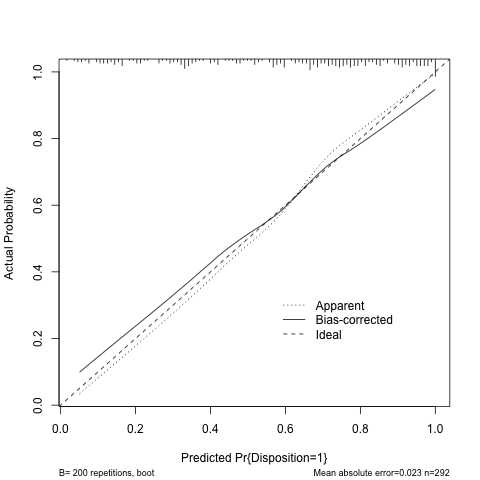

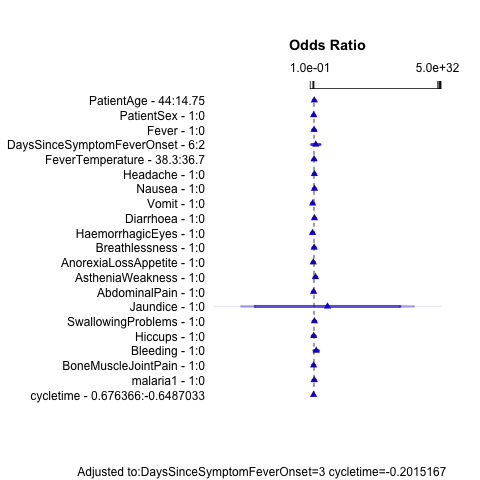

In [87]:
%%R -i num_imp,num_boot,sat_imp_formula,sat_lgr_formula,sat_folder,sat_vars

set.seed(random_seed)

# Impute data and fit pooled model
sat_impute <- aregImpute(as.formula(sat_imp_formula), data=src_data, n.impute=num_imp)
sat_model <- fit.mult.impute(as.formula(sat_lgr_formula), lrm, sat_impute, data=src_data)

# Calculate ANOVA and validation/calibration
sat_anova <- anova(sat_model)
sat_update <- update(sat_model, x=TRUE, y=TRUE)
sat_val <- validate(sat_update, B=num_boot)
sat_cal <- calibrate(sat_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
sat_datadist <- datadist(getImpute(impute = sat_impute, im = 1))


saveDescription(f=sat_model, vars=sat_vars, dir=sat_folder)
saveEvaluation(an=sat_anova, val=sat_val, cal=sat_cal, dir=sat_folder)

options(datadist='sat_datadist')
dir <- sat_folder
df <- getImpute(impute=sat_impute, im=1)
f <- sat_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)


# Variable selection with penalized regression

Here we use [Elastic Net Regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization) for variable selection. We run the regularized logistic regression with the [Glmnet package](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html) on each imputed dataset, and calculate how many times the coefficient for each variable over all the regressions is greater than zero. 

We are looking for variables that consistenly show non-negative coefficients since they represent clinical signs/symptoms at presentation that should be related with decreased changes of recovery. There are exceptions to this, for example cycletime has a negative coefficient since larger CT values indicate lower viral load and thus higher chances of recovery.

In [88]:
%%R -i num_imp,sat_imp_formula,include_age,include_temp,include_ctrt -o selection

selection <- selectVariables(random_seed, num_imp, sat_imp_formula, src_data, 
                             include_age, include_temp, include_ctrt)

Iteration 103 
(Intercept) 1 
AstheniaWeakness 1 
Jaundice 1 
Bleeding 1 
PatientAge1 1 
FeverTemperature1 0.98 
PatientAge2 0.97 
malaria1 0.88 
SwallowingProblems 0.63 
Breathlessness 0.59 
Diarrhoea 0.46 
Fever 0.32 
FeverTemperature2 0.26 
Nausea 0.04 
Headache 0.03 
PatientSex 0 
DaysSinceSymptomFeverOnset 0 
Vomit 0 
HaemorrhagicEyes 0 
AnorexiaLossAppetite 0 
AbdominalPain 0 
Hiccups 0 
BoneMuscleJointPain 0 
cycletime 0 
ct_rt 0 


We set the threshold for keeping a variable at +50% in the above list, meaning that the corresponding regression coefficient had to be positive at least in half of the models to be selected. As mentioned CT has a negative coefficient, and patient age and fever temperature are pre-determined, so we will only look at sign/symptoms above that threshold:

In [89]:
names = list(selection[0])
fraction = list(selection[1])

# These are predetermined, or not a model variable (i.e.: the intercept)
excluded = ['(Intercept)', 'PatientAge1', 'PatientAge2', 'FeverTemperature1', 'FeverTemperature2']

print('Variables to keep:')
for i in range(0, len(names)):
    if not names[i] in excluded and fraction[i] > 0.5:
        print(names[i], fraction[i])

Variables to keep:
AstheniaWeakness 1.0
Jaundice 1.0
Bleeding 1.0
malaria1 0.88
SwallowingProblems 0.63
Breathlessness 0.59


# Parsimonious model

In [90]:
pars_vars = ['PatientAge', 'cycletime', 'malaria1',
             'FeverTemperature',
             'Jaundice', 'Bleeding', 'Breathlessness', 'SwallowingProblems', 'AstheniaWeakness',
             'DaysSinceSymptomFeverOnset', 'DaysSinceSymptomFeverOnset*cycletime']

if use_sat_impute: 
    pars_imp_formula = sat_imp_formula 
else: 
    pars_imp_formula = makeImputeFormula(out_var, pars_vars)
    
pars_lgr_formula = makeLogRegFormula(out_var, pars_vars)
print(pars_imp_formula)
print(pars_lgr_formula)

pars_folder = createModelFolder('sl-parsimonious')

~Disposition+PatientAge+PatientSex+Fever+DaysSinceSymptomFeverOnset+FeverTemperature+Headache+Nausea+Vomit+Diarrhoea+HaemorrhagicEyes+Breathlessness+AnorexiaLossAppetite+AstheniaWeakness+AbdominalPain+Jaundice+SwallowingProblems+Hiccups+Bleeding+BoneMuscleJointPain+malaria1+cycletime
Disposition~rcs(PatientAge,3)+cycletime+malaria1+rcs(FeverTemperature,3)+Jaundice+Bleeding+Breathlessness+SwallowingProblems+AstheniaWeakness+DaysSinceSymptomFeverOnset+DaysSinceSymptomFeverOnset*cycletime


Iteration 103 

Variance Inflation Factors Due to Imputation:

                             Intercept                             PatientAge 
                                  1.47                                   1.17 
                           PatientAge'                              cycletime 
                                  1.18                                   1.53 
                              malaria1                       FeverTemperature 
                                  1.25                                   1.47 
                     FeverTemperature'                               Jaundice 
                                  1.45                                   1.00 
                              Bleeding                         Breathlessness 
                                  1.11                                   1.11 
                    SwallowingProblems                       AstheniaWeakness 
                                  1.10                              

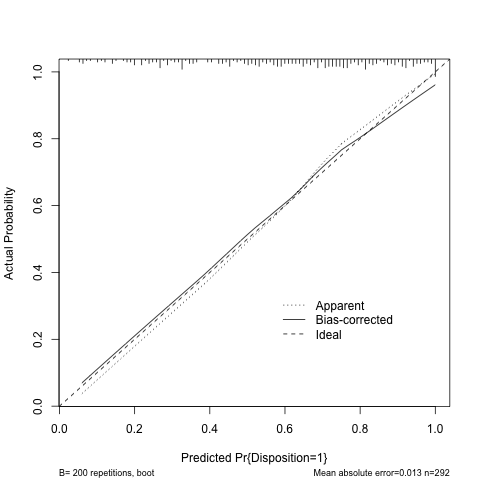

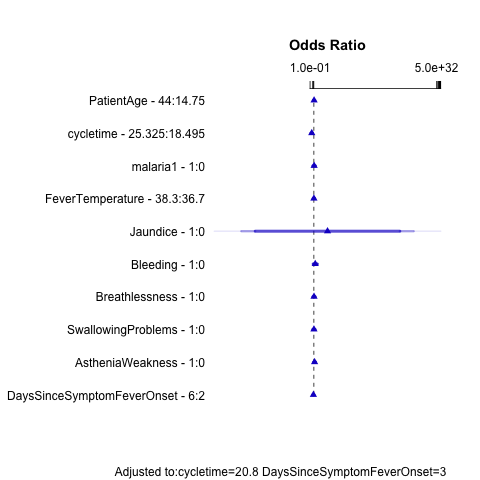

In [91]:
%%R -i num_imp,num_boot,pars_imp_formula,pars_lgr_formula,pars_vars,pars_folder

# generateModel(random_seed, num_imp, num_boot, pars_imp_formula, pars_lgr_formula, 
#               src_data, pars_vars, pars_folder)



set.seed(random_seed)

# Impute data and fit pooled model
pars_impute <- aregImpute(as.formula(pars_imp_formula), data=src_data, n.impute=num_imp)
pars_model <- fit.mult.impute(as.formula(pars_lgr_formula), lrm, pars_impute, data=src_data)

# Calculate ANOVA and validation/calibration
pars_anova <- anova(pars_model)
pars_update <- update(pars_model, x=TRUE, y=TRUE)
pars_val <- validate(pars_update, B=num_boot)
pars_cal <- calibrate(pars_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
pars_datadist <- datadist(getImpute(impute = pars_impute, im = 1))


saveDescription(f=pars_model, vars=pars_vars, dir=pars_folder)
saveEvaluation(an=pars_anova, val=pars_val, cal=pars_cal, dir=pars_folder)

options(datadist='pars_datadist')
dir <- pars_folder
df <- getImpute(impute=pars_impute, im=1)
f <- pars_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)